<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-Bethe-lattice-subgraph" data-toc-modified-id="Create-a-Bethe-lattice-subgraph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a Bethe lattice subgraph</a></span></li><li><span><a href="#Get-contraction-cost-estimations" data-toc-modified-id="Get-contraction-cost-estimations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get contraction cost estimations</a></span></li><li><span><a href="#Bethe-lattice-subgraphs-complexity-estimation" data-toc-modified-id="Bethe-lattice-subgraphs-complexity-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bethe lattice subgraphs complexity estimation</a></span></li></ul></div>

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import qtensor as qt
from cartesian_explorer import Explorer
import cartesian_explorer.caches as caches


In [93]:
ex = Explorer(cache=caches.JobLibCache(cachedir='../../data/cache/tree_subgraph2'))

## Create a Bethe lattice subgraph

In [118]:
@ex.provider
def bethe_graph(p, degree):
    def add_two_nodes_to_leafs(graph):
        """ Works in-place """
        leaves = [n for n in graph.nodes() if graph.degree(n) <= degree-2]
        n = graph.number_of_nodes()
        for leaf in leaves:
            next_edges = [(leaf, n+x) for x in range(1, degree)]
            graph.add_edges_from(next_edges)
            n += 2
    graph = nx.Graph()
    graph.add_edges_from([(0,1)])
    for i in range(p):
        add_two_nodes_to_leafs(graph)
    print('bethe lattice nodes', graph.number_of_nodes())
    return graph



req ('p', 'degree')


Text(0.5, 1.0, 'Bethe lattice subgraph for p=4')

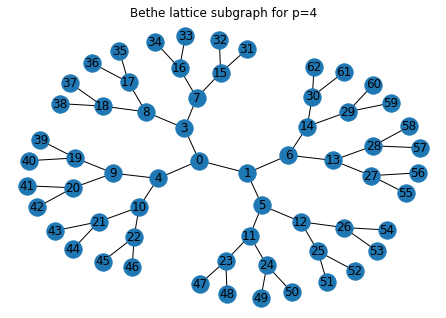

In [24]:
G = bethe_graph(p=4, degree=3)
nx.draw_kamada_kawai(G, with_labels=True)
plt.title('Bethe lattice subgraph for p=4')

In [95]:
@ex.provider
def bethe_lightcone_circuit(bethe_graph, 
                    beta, gamma):
    
    print('beta, gamma', beta,gamma)
    comp = qt.QtreeQAOAComposer(bethe_graph, gamma=gamma, beta=beta)
    comp.energy_expectation_lightcone((0, 1))
    return tuple(comp.circuit)
    

req ('bethe_graph', 'beta', 'gamma')


In [72]:
circ = bethe_lightcone_circuit(G, [0.1]*4, [0.2]*4)
print('Number of gates in circ: ', len(circ))

Number of gates in circ:  2086


## Get contraction cost estimations

In [96]:
@ex.provider
def circuit_sim_costs(bethe_lightcone_circuit):
    circuit = bethe_lightcone_circuit
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)
    opt = qt.optimisation.Optimizer.DefaultOptimizer()
    peo, _ = opt.optimize(tn)
    costs, mems = tn.simulation_cost(peo)
    return tuple(costs), tuple(mems)

@ex.provider
def max_memory(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return max(mems)

@ex.provider
def sum_flops(circuit_sim_costs):
    costs, mems = circuit_sim_costs
    return sum(costs)

req ('bethe_lightcone_circuit',)
req ('circuit_sim_costs',)
req ('circuit_sim_costs',)


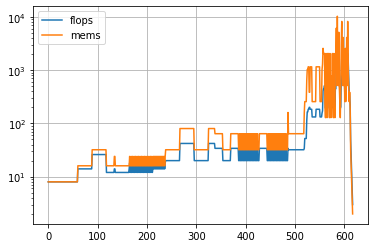

In [50]:
flops, mems = ex.get_variable('circuit_sim_costs', p=3, gamma=[0.2]*3, beta=[0.3]*3,
                    degree=[3]
                   )

plt.plot(flops, label='flops')
plt.plot(mems, label='mems')
plt.legend()
plt.yscale('log')
plt.grid()

In [98]:
@ex.provider
def expectation_value(bethe_lightcone_circuit):
    circuit = bethe_lightcone_circuit
    sim = qt.QtreeSimulator()
    E = sim.simulate(circuit)
    return E

req ('bethe_lightcone_circuit',)


In [82]:
gamma = np.array([-1.358922, 0.40041, -1.101348])
beta = np.array([-0.6072757, -0.45687, 0.2329651])
gamma *= -1/np.pi
beta *= 1/np.pi
E = ex.get_variable('expectation_value', p=3, degree=3,
                    gamma=gamma, beta=beta)
print('Expectation', E)

Expectation [-0.58477555+8.32667268e-17j]


In [110]:
@ex.add_function(provides=('beta', 'gamma'), requires='p')
def get_dummy_beta_gamma(p):
    beta = [.1]*p
    gamma = [.2]*p
    return tuple(beta), tuple(gamma)

## Bethe lattice subgraphs complexity estimation

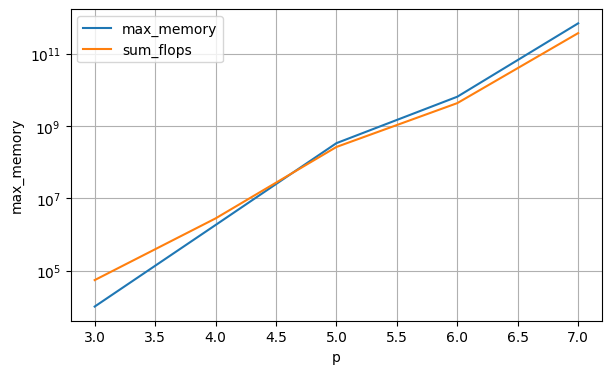

In [123]:
ps = [3, 4, 5, 6, 7]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.grid()
    plt.yscale('log')

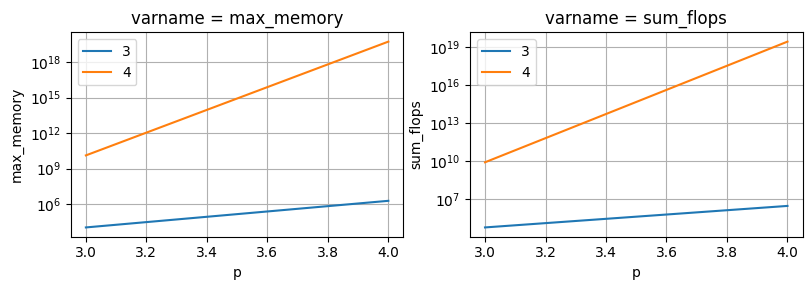

In [120]:
ps = [3, 4, ]
f = ex.plot_variables2d(('max_memory', 'sum_flops'),
                    degree = [3, 4],
                    p=ps,
                   )
for ax in f.axes:
    plt.sca(ax)
    plt.grid()
    plt.yscale('log')

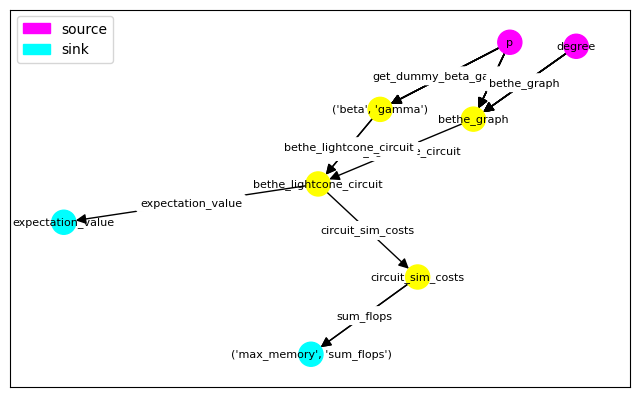

In [125]:
_ = ex.draw_dependency_graph()